In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tqdm
from math import sqrt
import random
from common import get_freq_data
# import seaborn as sns; 
# sns.set()

In [63]:
file = open('./data/na62_11_pulses.txt', 'r')
data = file.readlines()
data = np.array([list(map(float, experiment.split())) for experiment in data])
y = data[:, 0]
y_baseline = data[:, 1]
X = data[:, 2:]

In [3]:
print("Number of samples:", X.shape[0])
print("Dimension of each sample:", X.shape[1])

Number of samples: 1207
Dimension of each sample: 1024


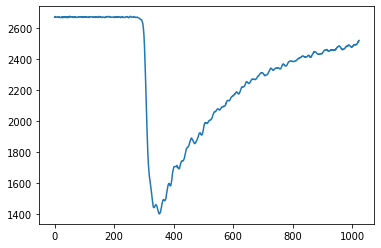

In [6]:
plt.plot(X[0])

Text(0.5, 1.0, 'Amplitudes distribution without filtering')

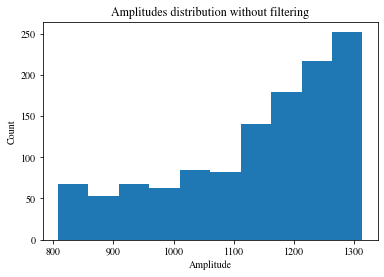

In [65]:
plt.hist(np.max(X, axis=1) - np.min(X, axis=1))
plt.xlabel("Amplitude")
plt.ylabel("Count")
plt.title("Amplitudes distribution without filtering")

In [13]:
TITLE_FONTSIZE = 17
LABEL_FONTSIZE = 16

In [14]:
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

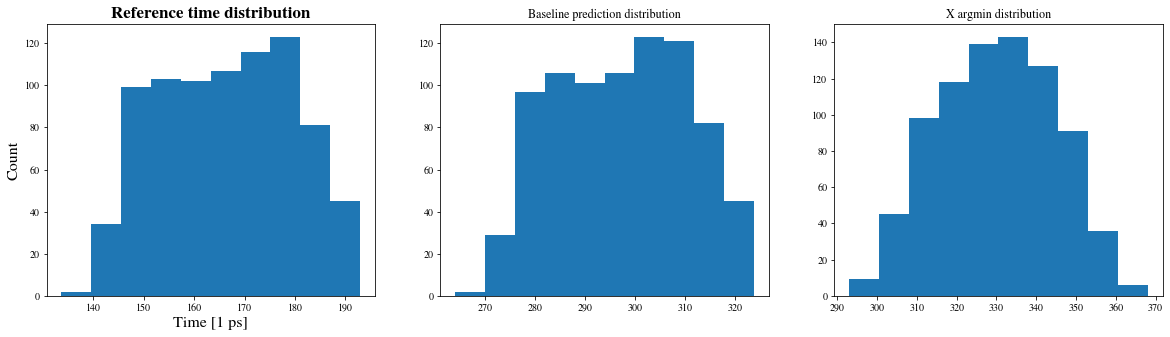

In [15]:
f, axarr = plt.subplots(1, 3, figsize=(20,5))
axarr[0].set_title("Reference time distribution", fontsize=TITLE_FONTSIZE, weight='bold')
axarr[0].hist(y)
axarr[0].set_xlabel("Time [1 ps]", fontsize=LABEL_FONTSIZE)
axarr[0].set_ylabel("Count", fontsize=LABEL_FONTSIZE)

axarr[1].set_title("Baseline prediction distribution")
axarr[1].hist(y_baseline)

axarr[2].set_title("X argmin distribution")
axarr[2].hist(np.argmin(X, axis=1))
plt.show()

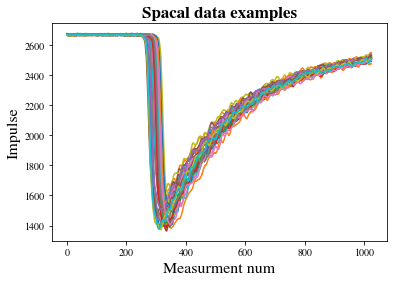

In [16]:
plt.title("Spacal data examples", fontsize=TITLE_FONTSIZE, weight='bold')
plt.xlabel("Measurment num", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
for i in range(30):
    plt.plot(X[i])
plt.show()

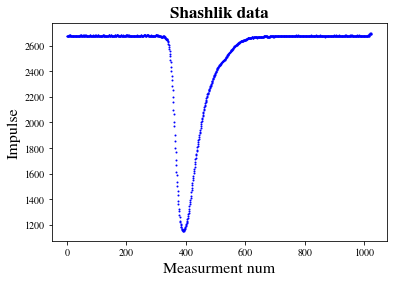

In [17]:
file = open('./data/shashlik_61_pulses.txt', 'r')
data = file.readlines()
data = np.array([list(map(float, experiment.split())) for experiment in data])
y = data[:, 0]
y_baseline = data[:, 1]
X = data[:, 2:]

plt.title("Shashlik data", fontsize=TITLE_FONTSIZE, weight='bold')
plt.xlabel("Measurment num", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.plot(X[2], 'ro', color='b', markersize=1)
plt.show()

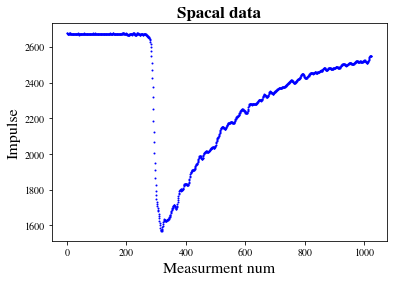

In [34]:
file = open('./data/na62_11_pulses.txt', 'r')
data = file.readlines()
data = np.array([list(map(float, experiment.split())) for experiment in data])
y = data[:, 0]
y_baseline = data[:, 1]
X = data[:, 2:]

plt.title("Spacal data", fontsize=TITLE_FONTSIZE, weight='bold')
plt.xlabel("Measurment num", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.plot(X[2], 'ro', color='b', markersize=1)
plt.show()

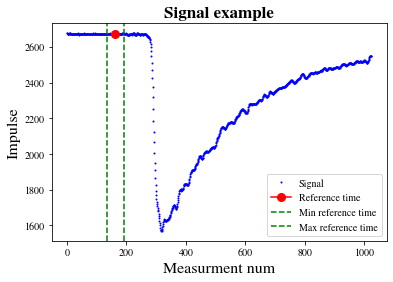

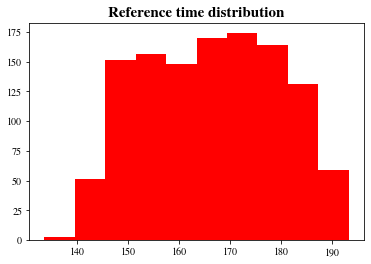

In [35]:
plt.plot(X[2], 'ro', color='b', markersize=1)
# plt.axvline(x=y[0], color='r')
plt.plot([int(y[2])], [X[2][int(y[2])]], color='r', marker='o', markersize=8)
plt.title("Signal example", fontsize=TITLE_FONTSIZE, weight='bold')
plt.xlabel("Measurment num", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
# plt.show()
plt.axvline(x=np.min(y), color='g', linestyle='--')
plt.axvline(x=np.max(y), color='g', linestyle='--')
plt.legend(['Signal', 'Reference time', 'Min reference time', 'Max reference time'])
plt.show()
plt.title("Reference time distribution", weight='bold', fontsize=15)
plt.hist(y, color='r')
plt.show()

In [66]:
X_new = []
y_new = []
y_new_baseline = []
threshold = 1100

for i in range(len(X)):
    if np.max(X[i]) - np.min(X[i]) > threshold:
        X_new.append(X[i])
        y_new.append(y[i])
        y_new_baseline.append(y_baseline[i])
        
X = np.array(X_new)
y = np.array(y_new)
y_baseline = np.array(y_new_baseline)

Text(0.5, 1.0, 'Amplitudes distribution after filtering')

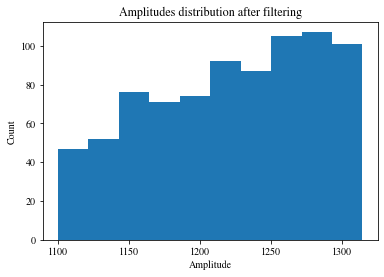

In [67]:
plt.hist(np.max(X, axis=1) - np.min(X, axis=1))
plt.xlabel("Amplitude")
plt.ylabel("Count")
plt.title("Amplitudes distribution after filtering")

### Normalize y

In [36]:
X.shape

(1207, 1024)

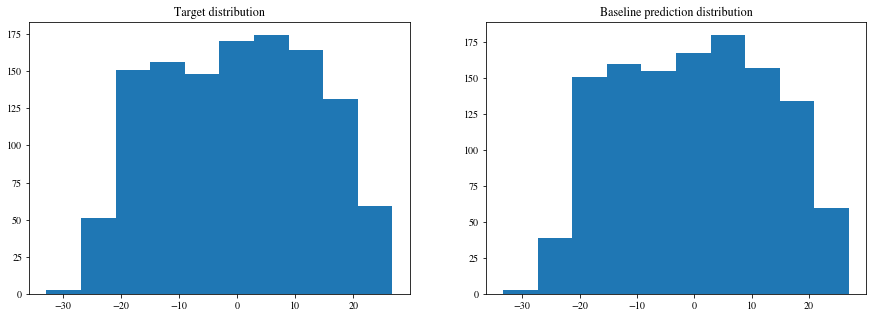

In [37]:
y = y - np.mean(y)
y_baseline = y_baseline - np.mean(y_baseline)

f, axarr = plt.subplots(1, 2, figsize=(15,5))
axarr[0].set_title("Target distribution")
axarr[0].hist(y)

axarr[1].set_title("Baseline prediction distribution")
axarr[1].hist(y_baseline)
plt.show()

### Model

In [38]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.preprocessing import PolynomialFeatures

In [39]:
TIME_SCALE_COEF = 0.2

def print_model_scores(X, y, model=LinearRegression()):
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X, y, scoring=scoring, cv=5)
    
    print("95% confidence interval:")
    print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
    print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
    print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
    print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

##### Linear regression metrics

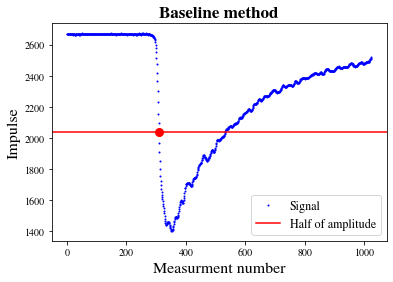

In [40]:
plt.plot(X[0], 'ro', color='b', markersize=1)
plt.axhline(y = np.min(X[0]) + (np.max(X[0] - np.min(X[0])))/2, color='r')
plt.plot(310, 2040, color='r', marker='o', markersize=8)

plt.title("Baseline method", fontsize=TITLE_FONTSIZE, weight='bold')
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.legend(['Signal', 'Half of amplitude'], prop={'size': 12})
plt.show()

### Freq dependency

In [60]:
TIME_SCALE_COEF = 0.2
ORIGIN_FREQ = 5000
TOP_SPACE = 0.93
freq_values = range(1, 102)

def get_errors(X, y, model, frequency_values, start_point=355, ):
    r2_scores = []
    mse_scores = []
    mae_scores = []
    rmse_scores = []
    for freq in tqdm.tqdm(frequency_values):
        X_freq = get_freq_data(X, freq=freq, start_point=start_point)

        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X_freq, y, scoring=scoring, cv=5)

        r2_scores.append(scores['test_r2'].mean())
        mse_scores.append(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean())
        mae_scores.append(TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean())
        rmse_scores.append(np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).mean())
        
        
    return {'r2': r2_scores, 'mse': mse_scores, 'mae': mae_scores, 'rmse': rmse_scores}

def plot_errors(errors1, errors2, frequency_values, model, xtick_freq=10, ):
    f, axarr = plt.subplots(2, 2, figsize=(15,15))
    st = f.suptitle(type(model).__name__, fontsize=20, weight='bold')
    f.subplots_adjust(top=TOP_SPACE)
    
    xticks = [i for i in range(0, len(frequency_values), xtick_freq)]
    xticklabels = [int(ORIGIN_FREQ/frequency_values[i])\
                                                for i in ([0] + list(range(9, len(frequency_values), xtick_freq)))]
    plt.setp(axarr, xticks=xticks, xticklabels=xticklabels)
    
    axarr[0, 0].set_title("R2 score", fontsize=TITLE_FONTSIZE, weight='bold')
    axarr[0, 0].set_ylabel("R2 score", fontsize=LABEL_FONTSIZE)
    axarr[0, 0].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    axarr[0, 0].plot(frequency_values, errors1['r2'])
    axarr[0, 0].plot(frequency_values, errors2['r2'])
    axarr[0, 0].legend(['Without filtering', 'With filtering'])

                            
    axarr[0, 1].set_title("MSE", fontsize=TITLE_FONTSIZE, weight='bold')
    axarr[0, 1].set_ylabel("MSE [ns^2]", fontsize=LABEL_FONTSIZE)
    axarr[0, 1].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    axarr[0, 1].plot(frequency_values, np.array(errors1['mse']))
    axarr[0, 1].plot(frequency_values, np.array(errors2['mse']))
    axarr[0, 1].legend(['Without filtering', 'With filtering'])

    
    
    axarr[1, 0].set_title("RMSE", fontsize=TITLE_FONTSIZE, weight='bold')
    axarr[1, 0].set_ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
    axarr[1, 0].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    axarr[1, 0].plot(frequency_values, np.array(errors1['rmse']))
    axarr[1, 0].plot(frequency_values, np.array(errors2['rmse']))
    axarr[1, 0].legend(['Without filtering', 'With filtering'])


    
    axarr[1, 1].set_title("MAE", fontsize=TITLE_FONTSIZE, weight='bold')
    axarr[1, 1].set_ylabel("MAE [ns]", fontsize=LABEL_FONTSIZE)
    axarr[1, 1].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    axarr[1, 1].plot(frequency_values, np.array(errors1['mae']))
    axarr[1, 1].plot(frequency_values, np.array(errors2['mae']))
    axarr[1, 1].legend(['Without filtering', 'With filtering'])

    plt.show()

In [ ]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective="reg:linear", random_state=42, verbosity=0)
X_scaled = np.array([experiment - np.max(experiment) for experiment in X])
X_scaled = np.array([experiment/-np.min(experiment) for experiment in X_scaled])    
X = X_scaled

errors = get_errors(X, y, xgb_reg, freq_values)

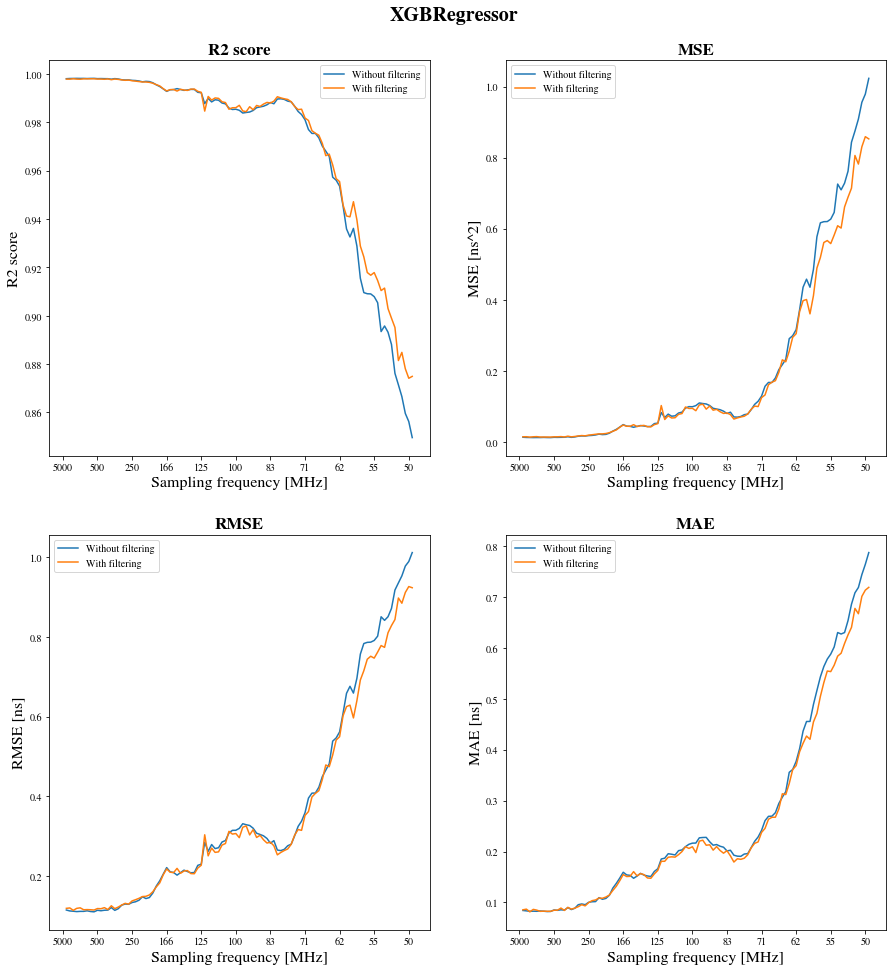

In [61]:
plot_errors(errors, errors_filtered, freq_values, xgb_reg)

In [42]:
errors_filtered['mae']

[0.08548694625377799,
 0.08677290896416891,
 0.081520237263486,
 0.08631776243065979,
 0.0848611957159634,
 0.08247815150904428,
 0.082842521061053,
 0.08259701590729894,
 0.08250117776032413,
 0.08466809703437429,
 0.08475282728008765,
 0.08890304353879146,
 0.08424950325684018,
 0.09024413156387112,
 0.08686056567856676,
 0.08875999173854676,
 0.09161424262744294,
 0.0955005691120675,
 0.09320890677057035,
 0.09955979305108714,
 0.10350699826103296,
 0.10482812711763889,
 0.10866693179993864,
 0.10814757154707624,
 0.11062566306379676,
 0.11459012722827107,
 0.123591427302654,
 0.13174444598890933,
 0.1426690891271727,
 0.154833343107605,
 0.1508730735220445,
 0.15133266474399226,
 0.16050233717488752,
 0.15219319010579202,
 0.1567785906768641,
 0.15459835668568223,
 0.14809648037073023,
 0.1475130799374511,
 0.1560760230924746,
 0.1629459377161897,
 0.18086012084307979,
 0.18086894999435704,
 0.1888496399290044,
 0.18964738353852809,
 0.18905294208616605,
 0.1939413351908136,
 0.200

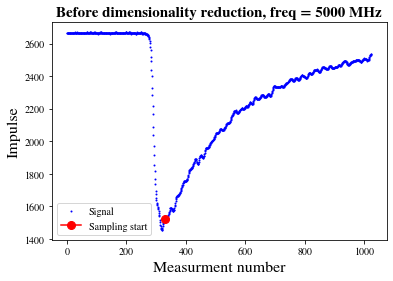

In [21]:
ORIGIN_FREQ = 5000
i = random.choice(range(len(X)))
freq=10

plt.title("Before dimensionality reduction, freq = %d MHz" %ORIGIN_FREQ, weight='bold', fontsize=15)
mean_argmin = int(np.mean(np.argmin(X, axis=1)))
plt.plot(X[i], 'ro', color='b', markersize=1)
plt.plot([mean_argmin], [X[i][int(mean_argmin)]], color='r', marker='o', markersize=8)
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)

plt.legend(['Signal', 'Sampling start'])
plt.show()

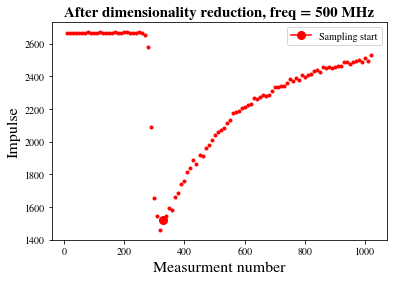

In [22]:
plt.title("After dimensionality reduction, freq = %d MHz" %(ORIGIN_FREQ/freq), weight='bold', fontsize=15)
plt.plot([mean_argmin], [X[i][int(mean_argmin)]], color='r', marker='o', markersize=8)
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.legend(['Sampling start'])

for pos in range(mean_argmin, 0, -freq):
    plt.plot([pos], X[i][pos], color='r', marker='o', markersize=3)
    
for pos in range(mean_argmin, len(X[i]), freq):
    plt.plot([pos], X[i][pos], color='r', marker='o', markersize=3)

### Scaling

In [23]:
X_scaled = np.array([experiment - np.max(experiment) for experiment in X])
X_scaled = np.array([experiment/-np.min(experiment) for experiment in X_scaled])    

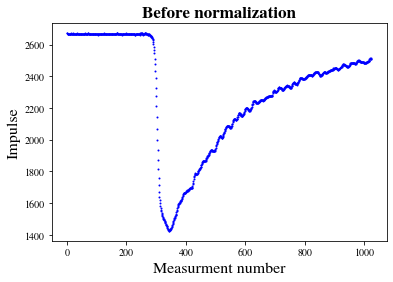

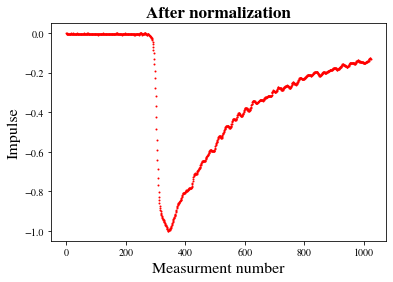

In [24]:
i = random.choice(range(len(X)))

plt.title("Before normalization", weight='bold', fontsize=TITLE_FONTSIZE)
plt.plot(X[i], 'ro', color='b', markersize=1)
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.show()

plt.title("After normalization", weight='bold', fontsize=TITLE_FONTSIZE)
plt.plot(X_scaled[i], 'ro', color='r', markersize=1)
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.show()

### Metrics

In [25]:
X = np.array([experiment - np.max(experiment) for experiment in X])
X = np.array([experiment/-np.min(experiment) for experiment in X])    

In [26]:
samples_sizes = range(100, 1000, 50)
rmse_scores = []
model=LinearRegression()

for samples_size in tqdm.tqdm(samples_sizes):
    X_new = X[:, :samples_size]
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X_new, y, scoring=scoring, cv=5)
    rmse_scores.append(TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean())

 28%|██▊       | 5/18 [00:05<00:13,  1.06s/it]


KeyboardInterrupt: 

In [27]:
print(list(samples_sizes))

[100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]


In [28]:
np.argmin(rmse_scores)

4

ValueError: x and y must have same first dimension, but have shapes (18,) and (5,)

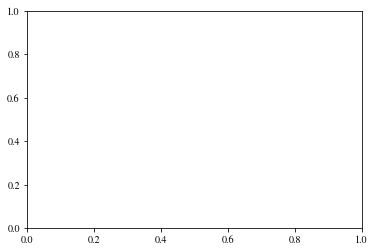

In [29]:
plt.plot(samples_sizes, rmse_scores)
plt.ylabel("RMSE")
plt.xlabel("Number of measurments for one sample")
plt.show()

In [30]:
print("Baseline metric:")
print("RMSE[ns]:", np.round(TIME_SCALE_COEF * sqrt(mean_squared_error(y, y_baseline)), decimals=5))
print("r2_score:", np.round(r2_score(y, y_baseline), decimals=5))
print("MSE[ns^2]:", np.round(TIME_SCALE_COEF**2 * mean_squared_error(y, y_baseline), decimals=5))
print("MAE[ns]:", np.round(TIME_SCALE_COEF * mean_absolute_error(y, y_baseline), decimals=5))

Baseline metric:
RMSE[ns]: 0.09752
r2_score: 0.99861
MSE[ns^2]: 0.00951
MAE[ns]: 0.07702


In [31]:
print_model_scores(X[:, :360], y)

95% confidence interval:
r2_score: 0.99547 (+/- 0.00164)
MSE[ns^2]: 0.03088 (+/- 0.05936)
RMSE[ns]: 0.17499 (+/- 0.03208)
MAE[ns]: 0.13427 (+/- 0.01180)


In [32]:
print_model_scores(X, y)

95% confidence interval:
r2_score: 0.95025 (+/- 0.02731)
MSE[ns^2]: 0.33791 (+/- 0.88018)
RMSE[ns]: 0.57627 (+/- 0.15263)
MAE[ns]: 0.44539 (+/- 0.09785)


In [19]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
model.coef_

array([ 27272.6195189 , -27299.04448604,     39.43882113, ...,
          -59.78293666,    -42.13586933,     32.93335666])

##### Baseline metrics

In [21]:
print("Baseline metric:")
print("r2_score:", np.round(r2_score(y, y_baseline), decimals=5))
print("MSE[ns^2]:", np.round(TIME_SCALE_COEF**2 * mean_squared_error(y, y_baseline), decimals=5))
print("RMSE[ns]:", np.round(TIME_SCALE_COEF * sqrt(mean_squared_error(y, y_baseline)), decimals=5))
print("MAE[ns]:", np.round(TIME_SCALE_COEF * mean_absolute_error(y, y_baseline), decimals=5))

Baseline metric:
r2_score: 0.99861
MSE[ns^2]: 0.00951
RMSE[ns]: 0.09752
MAE[ns]: 0.07702


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


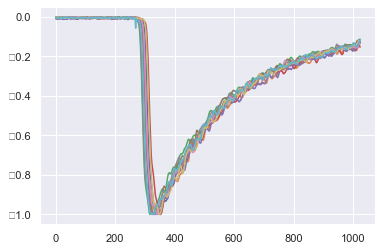

In [22]:
for i in range(10):
    plt.plot(X[i])

In [23]:
amplitude_half = np.min(X[0]) + (np.max(X[0] - np.min(X[0])))/2

### Feature engineering

In [39]:
half_implitude_locs = []

for signal in tqdm.tqdm(X):
    amplitude_half = np.min(signal) + (np.max(signal - np.min(signal)))/2
    cur_imp = signal[0]
    for i in range(1, len(signal)):
        next_imp = signal[i]

        if cur_imp > amplitude_half and amplitude_half >= next_imp:
            break
        cur_imp = next_imp
    half_implitude_locs.append(i)

100%|██████████| 1207/1207 [00:00<00:00, 7885.02it/s]


In [25]:
from scipy.stats.stats import pearsonr   

pearsonr(half_implitude_locs, y)

(0.9990222485525273, 0.0)

In [26]:
len(X)

1207

In [40]:
len(half_implitude_locs)

1207

In [41]:
X.shape

(1207, 1024)

In [42]:
X_new = np.zeros((X.shape[0], X.shape[1] + 1))

In [43]:
for i in range(len(X)):
    X_new[i] = np.append(X[i], [half_implitude_locs[i]])

In [33]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster='gbtree', eta=0.040967242033212566, 
                               gamma=0.11403358374490781, max_depth=42, reg_lambda=0.0010412564895330462,
                               alpha=9.720814421482372, verbosity=0)

In [35]:
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
scores = cross_validate(xgb_reg, X_scaled, y, scoring=scoring, cv=5)

print("95% confidence interval:")
print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

95% confidence interval:
r2_score: 0.99768 (+/- 0.00111)
MSE[ns^2]: 0.01582 (+/- 0.04030)
RMSE[ns]: 0.12482 (+/- 0.03096)
MAE[ns]: 0.08865 (+/- 0.00870)


In [36]:
print("XGB Regressor:")
print("95% confidence interval:")
print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))

XGB Regressor:
95% confidence interval:
RMSE[ns]: 0.12482 (+/- 0.03096)


In [44]:
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
scores = cross_validate(xgb_reg, X_new, y, scoring=scoring, cv=5)

print("95% confidence interval:")
print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

95% confidence interval:
r2_score: 0.99768 (+/- 0.00111)
MSE[ns^2]: 0.01582 (+/- 0.04030)
RMSE[ns]: 0.12482 (+/- 0.03096)
MAE[ns]: 0.08865 (+/- 0.00870)


In [45]:
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
scores = cross_validate(xgb_reg, np.array(half_implitude_locs).reshape(-1, 1), y, scoring=scoring, cv=5)

print("95% confidence interval:")
print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

95% confidence interval:
r2_score: 0.99778 (+/- 0.00058)
MSE[ns^2]: 0.01512 (+/- 0.01980)
RMSE[ns]: 0.12273 (+/- 0.01568)
MAE[ns]: 0.09548 (+/- 0.00528)


In [35]:
from common import get_freq_data

In [36]:
plt.plot(X_freq[0])

NameError: name 'X_freq' is not defined

In [58]:
pearsonr(np.argmin(X, axis=1), y)

(0.9013870868546854, 0.0)

(array([  3.,  38., 149., 157., 156., 165., 179., 160., 139.,  61.]),
 array([265., 271., 277., 283., 289., 295., 301., 307., 313., 319., 325.]),
 <a list of 10 Patch objects>)

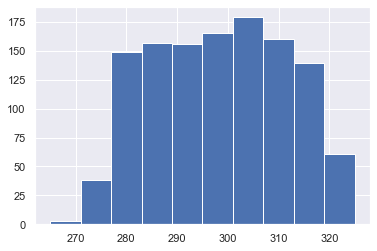

In [52]:
plt.hist(half_implitude_locs)

In [45]:
signal = X[0]

amplitude_half = np.min(signal) + (np.max(signal - np.min(signal)))/2
cur_imp = signal[0]
for i in range(1, len(signal)):
    next_imp = signal[i]
    
    if cur_imp > amplitude_half and amplitude_half >= next_imp:
        break
    cur_imp = next_imp

In [46]:
i

309